In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import trapezoid, simpson
from scipy.special import kv as besselk, jv as besselj, gamma
from scipy.constants import pi, Boltzmann as kb

def film_correlation_integrand_replacement(r, qxy, eta, Lk, amin): # Changes made
    r = np.asarray(r)  # Ensure r is a numpy array
    rad_term = np.sqrt(r[None, None, :]**2 + amin**2)  # r turned into r[None, None, :] b/c sizing errors when integrating and the [..., None] at the end was removed
    term1 = rad_term**(1 - eta[..., None])
    term2 = np.exp(-eta[..., None] * besselk(0, rad_term / Lk)) - 1
    term3 = besselj(0, rad_term * qxy[..., None])
    return term1 * term2 * term3

def film_integral_delta_beta_delta_phi(beta, phi, kbT_gamma, wave_number, alpha, Lk, amin):   # error arrises here
    beta = np.asarray(beta) # converting to numpy array for performance/vectorization
    phi = np.asarray(phi)
    
    qmax = pi / amin
    beta_rad = np.radians(beta)
    phi_rad = np.radians(phi)
    alpha_rad = np.radians(alpha)

    cosb = np.cos(beta_rad)
    sinb = np.sin(beta_rad)
    cosp = np.cos(phi_rad)
    sinp = np.sin(phi_rad)
    cosa = np.cos(alpha_rad)
    sina = np.sin(alpha_rad)

    qxy = wave_number * np.sqrt((cosb * sinp)**2 + (cosa - cosb * cosp)**2)
    qz = wave_number * (sina + sinb)
    eta = (kbT_gamma / (2 * pi)) * qz**2

    r_vals = np.linspace(0.001, 8 * Lk, 300)
    integrand_vals = film_correlation_integrand_replacement(r_vals, qxy, eta, Lk, amin)
    integral_vals = trapezoid(integrand_vals, r_vals, axis=-1) # might need axis = 1
    C_prime = 2 * pi * integral_vals

    xi = 2 ** (1 - eta) * gamma(1 - 0.5 * eta) / gamma(0.5 * eta) * (2 * np.pi) / (qz ** 2)    # xi used to = (2 * Lk) ** eta, but in MATLAB looks like: xi = (2.^(1-eta).*gamma(1-0.5*eta)./gamma(0.5*eta)) *2*pi./qz.^2;

    exp_term = np.exp(eta * besselk(0, 1 / (Lk * qmax)))
    result = (xi * qxy ** (eta - 2) + C_prime / qz**2) * (1 / qmax) ** eta * exp_term
    return result

def film_integral_delta_beta_delta_phi(beta, phi, kbT_gamma, wave_number, alpha, Lk, amin):   # error arrises here
    beta = np.asarray(beta) # converting to numpy array for performance/vectorization
    phi = np.asarray(phi)
    
    qmax = pi / amin
    beta_rad = np.radians(beta)
    phi_rad = np.radians(phi)
    alpha_rad = np.radians(alpha)

    cosb = np.cos(beta_rad)
    sinb = np.sin(beta_rad)
    cosp = np.cos(phi_rad)
    sinp = np.sin(phi_rad)
    cosa = np.cos(alpha_rad)
    sina = np.sin(alpha_rad)

    qxy = wave_number * np.sqrt((cosb * sinp)**2 + (cosa - cosb * cosp)**2)
    qz = wave_number * (sina + sinb)
    eta = (kbT_gamma / (2 * pi)) * qz**2

    r_vals = np.linspace(0.001, 8 * Lk, 300)
    integrand_vals = film_correlation_integrand_replacement(r_vals, qxy, eta, Lk, amin)
    integral_vals = trapezoid(integrand_vals, r_vals, axis=-1) # might need axis = 1
    C_prime = 2 * pi * integral_vals

    xi = 2 ** (1 - eta) * gamma(1 - 0.5 * eta) / gamma(0.5 * eta) * (2 * np.pi) / (qz ** 2)    # xi used to = (2 * Lk) ** eta, but in MATLAB looks like: xi = (2.^(1-eta).*gamma(1-0.5*eta)./gamma(0.5*eta)) *2*pi./qz.^2;

    exp_term = np.exp(eta * besselk(0, 1 / (Lk * qmax)))
    result = (xi * qxy ** (eta - 2) + C_prime / qz**2) * (1 / qmax) ** eta * exp_term
    return result


def film_integral_approx_delta_beta_delta_phi(beta, phi, kbT_gamma, wave_number, alpha, Lk, amin):
    qmax = pi / amin
    beta_rad = np.radians(beta)
    phi_rad = np.radians(phi)
    alpha_rad = np.radians(alpha)

    cosb = np.cos(beta_rad)
    sinb = np.sin(beta_rad)
    cosp = np.cos(phi_rad)
    sinp = np.sin(phi_rad)
    cosa = np.cos(alpha_rad)
    sina = np.sin(alpha_rad)

    qxy = wave_number * np.sqrt((cosb * sinp)**2 + (cosa - cosb * cosp)**2)
    qz = wave_number * (sina + sinb)
    eta = (kbT_gamma / (2 * pi)) * qz**2

    result = kbT_gamma * (1 / qmax)**eta * np.exp(eta * besselk(0, 1 / (Lk * qmax))) * qxy**eta / (qxy**2 + (Lk**2) * qxy**4)
    return result


# -------------------- Main Calculation -------------------- #

def calc_film_DS_RRF_integ(beta_space, qxy0, energy, alpha, Rqxy_HWHM, DSqxy_HWHM, DSbeta_HWHM,
                           tension, temp, kapa, amin, use_approx=False, show_plot=True):
    qmax = pi / amin
    wavelength = 12.4 / energy
    wave_number = 2 * pi / wavelength
    qz_space = (np.sin(np.radians(alpha)) + np.sin(np.radians(beta_space))) * wave_number

    phi = 2 * np.degrees(np.arcsin(qxy0 / (2 * wave_number)))
    phi_HWHM = np.degrees(DSqxy_HWHM * wavelength / (2 * pi))
    phi_upper = phi + phi_HWHM
    phi_lower = phi - phi_HWHM

    beta_upper = beta_space + DSbeta_HWHM
    beta_lower = beta_space - DSbeta_HWHM

    kbT_gamma = kb * temp / tension * 1e20
    Lk = np.sqrt(kapa * kb * temp / tension) * 1e10
    eta = (kbT_gamma / (2 * pi)) * qz_space**2

    xi = (2 ** (1 - eta)) * (gamma(1 - 0.5 * eta) / gamma(0.5 * eta)) * 2 * pi / qz_space**2

    r_vals = np.linspace(0.001, 8 * round(Lk), 1000)
    r_grid = np.sqrt(r_vals**2 + amin**2)
    C_integrand = np.zeros((len(qz_space), len(r_vals)))

    for idx, eta_val in enumerate(eta):
        C_integrand[idx, :] = 2 * pi * r_grid**(1 - eta_val) * (np.exp(-eta_val * besselk(0, r_grid / Lk)) - 1)

    C = trapezoid(C_integrand, r_vals, axis=1)
    RRF_term = ((xi / kbT_gamma) * Rqxy_HWHM**eta + Rqxy_HWHM**2 * C / (4 * pi)) * (1 / qmax)**eta * np.exp(eta * besselk(0, 1 / (Lk * qmax)))

    DS_term = np.zeros(len(beta_space))
    phi_grid = np.linspace(phi_lower, phi_upper, 100)

    for idx, beta in enumerate(beta_space):
        beta_grid = np.linspace(beta_lower[idx], beta_upper[idx], 100)
        beta_mesh, phi_mesh = np.meshgrid(beta_grid, phi_grid, indexing='ij')

        if use_approx:
            vals = film_integral_approx_delta_beta_delta_phi(beta_mesh, phi_mesh, kbT_gamma, wave_number, alpha, Lk, amin)
        else:
            vals = film_integral_delta_beta_delta_phi(beta_mesh, phi_mesh, kbT_gamma, wave_number, alpha, Lk, amin)

        DS_term[idx] = simpson(simpson(vals, phi_grid), beta_grid)

    DS_RRF = DS_term / RRF_term

    if show_plot:
        label_mode = "Approx" if use_approx else "Accurate"
        plt.figure(figsize=(8, 5))
        plt.plot(qz_space, DS_RRF / DS_RRF[0], label=f"{label_mode} Qxy₀={qxy0:.3f} Å⁻¹", linewidth=1.5)
        plt.xlabel(r"$Q_z$ [$\AA^{-1}$]", fontsize=12)
        plt.ylabel(r"DS / (R/R$_F$)", fontsize=12)
        plt.xlim(0, 1.2)
        plt.grid(True)
        plt.legend(loc="upper left", frameon=False)
        plt.title(f"GIXOS factor ({label_mode})")
        plt.tight_layout()
        plt.show()

    return DS_RRF, DS_term, RRF_term

In [ ]:
#Dependency File Below
import numpy as np
colorset = [    [0, 0.4470, 0.7410],
                [0.8500, 0.3250, 0.0980], 
                [0.9290, 0.6940, 0.1250],
                [0.4940, 0.1840, 0.5560],
                [0.4660, 0.6740, 0.1880],
                [0.3010, 0.7450, 0.9330],
                [0.6350, 0.0780, 0.1840],
                [0, 0.4470, 0.7410],
                [0.8500, 0.3250, 0.0980],
                [0.9290, 0.6940, 0.1250]
]

In [ ]:
gamma_E = 0.5772156649015329 # supposed to import math and use math.euler_gamma but did not work -- constant
Qc = 0.0217   # Scientist inputs -- see email for meaning of most vars
energy = 14400
alpha_i = 0.0728
Ddet = 710
pixel = 0.172
footprint = 10
wavelength = 12404/energy
qxy0 = np.array([0.04, 0.06, 0.10, 0.15, 0.318])  # In MATLAB, we have: [0.04, 0.05, 0.06, 0.08, 0.1, 0.15, 0.2, 0.25, 4*pi/geo.wavelength*np.sin(np.radians([2.5:0.25:3]/2))]
#qxy0_select_idx = 0 # needs to follow Python indexing; -1 value of MATLAB

qxy_bkg = 0.3
RqxyHW = 0.0002
DSresHW = 0.003
DSpxHW = 3.5      
DSqxyHW = 2 * DSresHW
qz_selected = np.array([0.1, 0.3, 0.35, 0.4, 0.6])


In [ ]:
path = "C:/Users/alexp/OneDrive/PseudoXRR/10mM_CaCl2_pH7p03_100ppm_PFOA_1/"         # decided by user for where the files should be from and stored
path_out = "C:/Users/alexp/OneDrive/PseudoXRR/Processed/"
sample = "instrument"
scan = np.arange(46392, 46401, 2)
bkgsample = 'instrument'
bkgscan = scan+1

I0ratio_sample2bkg = 1

kb = 1.381E-23 # Boltzmann constant, J/K
tension = 50/1000 # tension, [N/m]
kappa = 20
kappa_deviation = 5
assume_kappa = np.array([kappa - kappa_deviation, kappa + kappa_deviation])
temperature = 293 # [K]
Lk = np.sqrt(kappa*kb*temperature/tension)*10**10
amin = 5
eta = kb*temperature / (tension * 2 * np.pi) * 10**20 * (qz_selected)**2
rho_b = 9.42E-6
RFscaling = I0ratio_sample2bkg * 1*10**11 * 55/3/7 * (np.pi/180)**2 * (rho_b)**2 / np.sin(np.radians(alpha_i))*4

In [ ]:
importGIXOSdata = None
importbkg = None

for idx in range(len(qxy0)):
    fileprefix = f"{sample}-id{int(scan[idx])}"        # sample + "-id" + int(scan[idx],'%d')  # fix later
    GIXOSfilename = path + fileprefix + ".txt"
    importGIXOSdata_qxy0 = np.loadtxt(GIXOSfilename, skiprows = 16)
    #importGIXOSdata_qxy0 = importGIXOSdata_qxy0.to_numpy() 
    if importGIXOSdata is None:
        importGIXOSdata = {
        "Intensity": np.zeros((importGIXOSdata_qxy0.shape[0], len(qxy0))),
        "tt_qxy0": np.zeros((importGIXOSdata_qxy0.shape[0], len(qxy0))),
        "error": np.zeros((importGIXOSdata_qxy0.shape[0], len(qxy0))),
        "tt": np.zeros((importGIXOSdata_qxy0.shape[0], len(qxy0))),
    }  

    # Compute element-wise mean
    mean_row = np.mean(importGIXOSdata_qxy0[[268, 270], :], axis=0)

    # Assign the mean to row 269
    importGIXOSdata_qxy0[269, :] = mean_row   # .data is the name of the column, so need to convert that to Python list access

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # importGIXOSdata is an underfined var, except in MATLAB it did not have any initialization prior to this
    importGIXOSdata ["Intensity"][:, idx] = importGIXOSdata_qxy0[:,2]
    importGIXOSdata ["tt_qxy0"][:,idx] = importGIXOSdata_qxy0 [:,1] # - 0.01
    importGIXOSdata ["error"][:,idx] = np.sqrt(importGIXOSdata_qxy0 [:,2]) # might run into errors bc math only works for scalars & not arrays   

    #file name of the bkg GISAXS to be imported
    bkgfileprefix = f"{bkgsample}-id{int(bkgscan[idx])}"
    bkgGIXOSfilename = path + bkgfileprefix + ".txt"
    importbkg_qxy0 = np.loadtxt(bkgGIXOSfilename, skiprows = 16)
    #importbkg_qxy0 = importbkg_qxy0.to_numpy()    # ~~~~~~~~~~~~~~~~~~~ Use to import using pandas with:   importbkg_qxy0 = pd.read_csv(filename, delimiter=' ', skiprows=16)    but did not read well; would skip a line at first can likely rewrite with pandas if needed
    if importbkg is None:
        importbkg = {
             "Intensity": np.zeros((importbkg_qxy0.shape[0], len(qxy0) )),
            "tt_qxy0": np.zeros((importbkg_qxy0.shape[0], len(qxy0))),
            "error": np.zeros((importbkg_qxy0.shape[0], len(qxy0))),
             "tt": np.zeros((importbkg_qxy0.shape[0], len(qxy0))),
        }

    importbkg_qxy0 [269,:] = np.mean(importbkg_qxy0 [[268,270],:], axis=0); # bad pixel
    importbkg ["Intensity"][:,idx] = importbkg_qxy0 [:,2]
    importbkg ["tt_qxy0"][:,idx] = importGIXOSdata_qxy0 [:,1]
    importbkg ["error"][:,idx] = np.sqrt(importbkg_qxy0 [:,2])

    if (scan[idx]>=29646 and scan[idx]<=29682):
        importGIXOSdata ["Intensity"][:,idx] = importGIXOSdata ["Intensity"][:,idx]*2
        importGIXOSdata ["error"][:,idx] = np.sqrt(importGIXOSdata ["Intensity"][:,idx])
        importbkg ["Intensity"][:,idx] = importbkg ["Intensity"][:,idx]*2
        importbkg ["error"][:,idx] = np.sqrt(importbkg ["Intensity"][:,idx])
    print(f"{qxy0[idx]:f}", end='\t')     #      fprintf('%f/t', qxy0[idx])        # what i had initially was:   print('/t'.join(f"{qxy0[idx]:f}"))
    
importGIXOSdata ["tt"] = np.mean(importGIXOSdata ["tt_qxy0"], axis = 1)
importbkg ["tt"] = np.mean(importbkg ["tt_qxy0"], axis = 1)

0.040000	0.060000	0.100000	0.150000	0.318000	

In [ ]:
binsize = 10
groupnumber =  int(np.floor(importGIXOSdata ["Intensity"].shape[0] / binsize))      # look at the first row with .shape[0]
num_columns = importGIXOSdata["Intensity"].shape[1]

binneddata = None
binnedbkg = None

for groupidx in range(groupnumber): # why can't we just round up before if we are adding 1 to it?
    start = groupidx * binsize
    end = (groupidx + 1) * binsize
   
    if binneddata is None:
        binneddata = {
        "Intensity": np.zeros((groupnumber, num_columns)),
        "tt": np.zeros(groupnumber),
    } 

    binneddata ["Intensity"][groupidx, :] = np.sum(importGIXOSdata ["Intensity"][start:end, :], axis=0)
    binneddata ["tt"][groupidx] = np.mean(importGIXOSdata ["tt"][start:end])

    if binnedbkg is None:
        binnedbkg = {
        "Intensity": np.zeros((groupnumber, num_columns)),
        "tt": np.zeros(groupnumber),
    }
    binnedbkg ["Intensity"][groupidx, :] = np.sum(importbkg ["Intensity"][start:end, :], axis=0)
    binnedbkg ["tt"][groupidx] = np.mean(importbkg ["tt"][start:end])    # no [ , :] because would index through all columns but we only have 1 in ["tt"]

importGIXOSdata = binneddata
importbkg = binnedbkg

In [ ]:
tt_step = np.mean(importGIXOSdata ["tt"][1:] - importGIXOSdata ["tt"][0:-1])
indices =  np.where(importGIXOSdata ["tt"] < 0)[0] # finding indices where value stored is less than 0
tt_start_idx = indices[-1] if len(indices) > 0 else None  # taking the last  value of indices, and checking if indices is a valid list to take from

importGIXOSdata["Intensity"] = importGIXOSdata["Intensity"][tt_start_idx+1 :,:]
importGIXOSdata["tt"] = importGIXOSdata["tt"][tt_start_idx+1 :]
importbkg["Intensity"] = importbkg["Intensity"][tt_start_idx+1 :,:]
importbkg["tt"] = importbkg["tt"][tt_start_idx+1 :]  # in essence, we are removing the first rows of the data that have negative tt values

In [ ]:
tth = np.degrees(np.arcsin(qxy0 * wavelength / 4 / np.pi)) * 2          # math.asin would work if not a list
tth_roiHW_real = np.degrees(pixel * DSpxHW / Ddet)
DSqxyHW_real = np.radians(tth_roiHW_real) / 2 * 4 * np.pi / wavelength * np.cos(np.radians(tth/2))

#Same as MATLAB

In [ ]:
GIXOS = {
    "tt": importGIXOSdata["tt"],
    # "GIXOS_raw": importGIXOSdata["Intensity"] [:, qxy0_select_idx],
    # "GIXOS_bkg": importbkg["Intensity"] [:, qxy0_select_idx]
}
DSbetaHW = np.mean(GIXOS["tt"][1:] - GIXOS["tt"][0:-1]) / 2
qxy0_idx_arr = np.where(qxy0 > qxy_bkg)
if len(qxy0_idx_arr) == 0:
    qxy0_idx = len(qxy0) + 1
else:
    qxy0_idx = int(qxy0_idx_arr[0])

GIXOS["Qxy"] = np.zeros((len(GIXOS["tt"]), qxy0_idx))
for idx in range(qxy0_idx):
    GIXOS["Qxy"][:, idx] = 2 * np.pi / wavelength * np.sqrt((np.cos(np.radians(GIXOS["tt"])) * np.sin(np.radians(tth[idx])))**2 + (np.cos(np.radians(alpha_i)) - np.cos(np.radians(GIXOS["tt"])) * np.cos(np.radians(tth[idx])))**2)
GIXOS["Qz"] = 2 * np.pi / wavelength * (np.sin(np.radians(GIXOS["tt"])) + np.sin(np.radians(alpha_i)))
GIXOS["GIXOS_raw"] = importGIXOSdata["Intensity"] [:, :qxy0_idx]
GIXOS["GIXOS_bkg"] = importbkg["Intensity"] [:, :qxy0_idx]
if qxy0_idx <= len(qxy0):
    GIXOS_raw_largetth = np.mean(importGIXOSdata["Intensity"][:, qxy0_idx:], axis = 1)
    GIXOS_bkg_largetth = np.mean(importbkg["Intensity"][:, qxy0_idx:], axis = 1)
    bulkbkg = GIXOS_raw_largetth - GIXOS_bkg_largetth
else:
    bulkbkg = np.zeros(len(qxy0), 1)

fdtt = np.radians(tt_step) / (np.arctan((np.tan(np.radians(GIXOS ["tt"]))*Ddet + pixel/2)/Ddet) - np.arctan((np.tan(np.radians(GIXOS ["tt"]))*Ddet - pixel / 2) / Ddet))
fdtt = fdtt / fdtt [0]
fdtt = fdtt[:, np.newaxis]

GIXOS["GIXOS"] = (GIXOS ["GIXOS_raw"] - GIXOS ["GIXOS_bkg"]) * fdtt - np.mean(bulkbkg[-1 - 10:], axis = 0) * fdtt
GIXOS["error"] = np.sqrt(np.sqrt(np.abs(GIXOS["GIXOS_raw"])) **2 + np.sqrt(np.abs(GIXOS["GIXOS_bkg"]))**2) * fdtt
GIXOS["bkg"] = 0

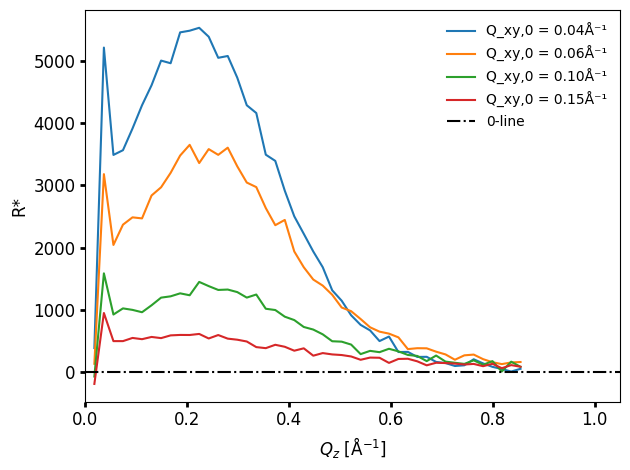

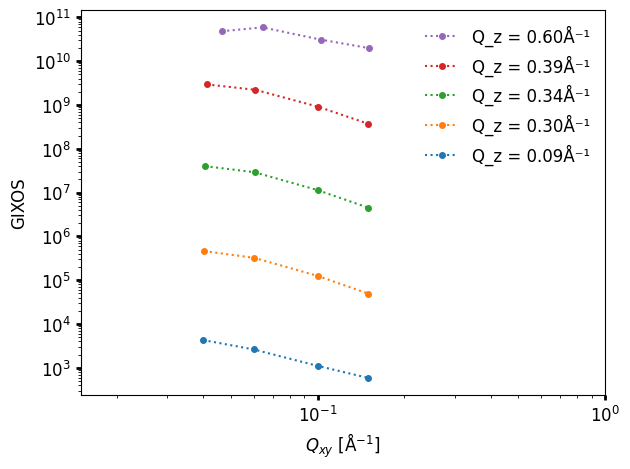

In [ ]:
import matplotlib.pyplot as plt

# Plot GIXOS vs Qz for each Qxy_0
plt.close('all')
fig_refl = plt.figure("raw")
for idx in range(GIXOS["GIXOS"].shape[1]):
    label = f"Q_xy,0 = {qxy0[idx]:.2f}Å⁻¹"
    plt.plot(GIXOS["Qz"], GIXOS["GIXOS"][:, idx] - GIXOS["bkg"], '-', linewidth=1.5, label=label)
plt.axhline(0, color='k', linestyle='-.', linewidth=1.5, label='0-line')
plt.xlim([0, 1.05])
plt.xlabel(r'$Q_z$ [$\mathrm{\AA}^{-1}$]', fontsize=12)
plt.ylabel("R*", fontsize=12)
plt.xticks(np.arange(0, 1.1, 0.2))
plt.legend(loc='upper right', frameon=False)
ax = plt.gca()
ax.tick_params(direction='out', width=2, labelsize=12)
plt.tight_layout()
plt.savefig(f"{path_out}{sample}_{min(scan):05d}_{max(scan):05d}_raw_all.jpg")

# Plot GIXOS vs Qxy at selected Qz
fig_refl_qxy = plt.figure("raw Qxy")
for idx, qz_val in enumerate(qz_selected):
    plotrowidx = np.where(GIXOS["Qz"] <= qz_val)[0]
    if len(plotrowidx) == 0:
        continue
    plotrowidx = plotrowidx[-1]
    start = max(plotrowidx - 3, 0)
    end = min(plotrowidx + 4, GIXOS["GIXOS"].shape[0])
    ydata = np.mean(GIXOS["GIXOS"][start:end, :] - GIXOS["bkg"], axis=0) * 100 ** idx
    label = f"Q_z = {GIXOS['Qz'][plotrowidx]:.2f}Å⁻¹"
    plt.plot(GIXOS["Qxy"][plotrowidx, :], ydata, 'o:', markersize=4, linewidth=1.5, label=label)
plt.xlim([0.015, 1])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$Q_{xy}$ [$\mathrm{\AA}^{-1}$]', fontsize=12)
plt.ylabel("GIXOS", fontsize=12)
ax = plt.gca()
ax.tick_params(direction='out', width=2, labelsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=12, reverse = True) # added reverse to match the order that the lines are plotted in the 2nd graph (also see last cell)
plt.tight_layout()


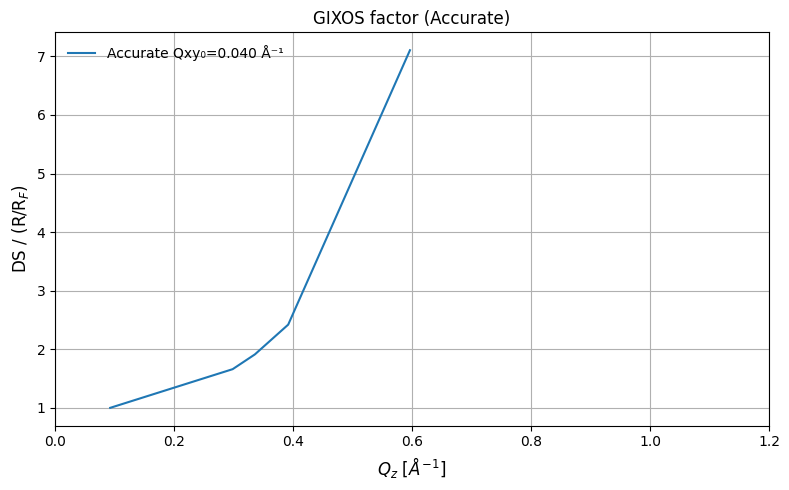

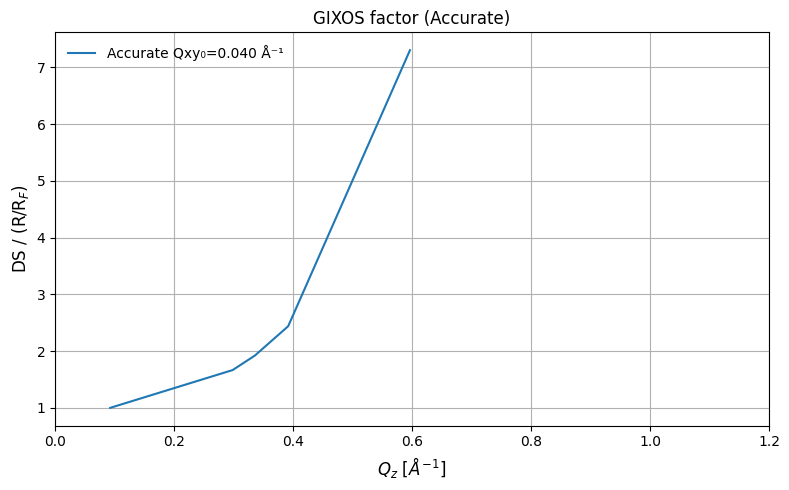

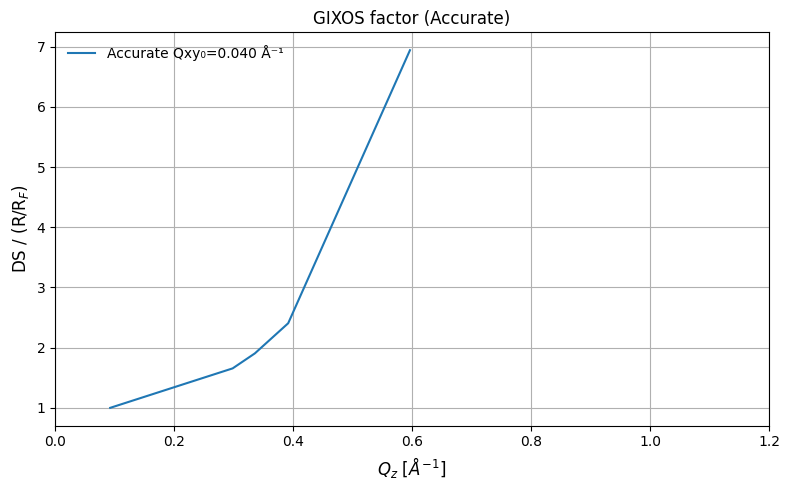

C:\Users\alexp\AppData\Local\Temp\ipykernel_27932\1444226637.py:128: RuntimeWarning: divide by zero encountered in divide
  C_integrand[idx, :] = 2 * pi * r_grid**(1 - eta_val) * (np.exp(-eta_val * besselk(0, r_grid / Lk)) - 1)
C:\Users\alexp\AppData\Local\Temp\ipykernel_27932\1444226637.py:131: RuntimeWarning: divide by zero encountered in scalar divide
  RRF_term = ((xi / kbT_gamma) * Rqxy_HWHM**eta + Rqxy_HWHM**2 * C / (4 * pi)) * (1 / qmax)**eta * np.exp(eta * besselk(0, 1 / (Lk * qmax)))
C:\Users\alexp\AppData\Local\Temp\ipykernel_27932\1444226637.py:12: RuntimeWarning: divide by zero encountered in divide
  term2 = np.exp(-eta[..., None] * besselk(0, rad_term / Lk)) - 1
C:\Users\alexp\AppData\Local\Temp\ipykernel_27932\1444226637.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  exp_term = np.exp(eta * besselk(0, 1 / (Lk * qmax)))


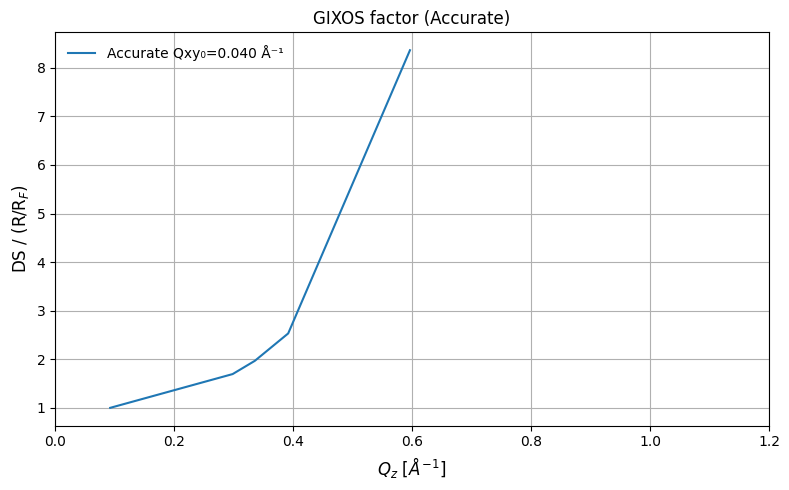

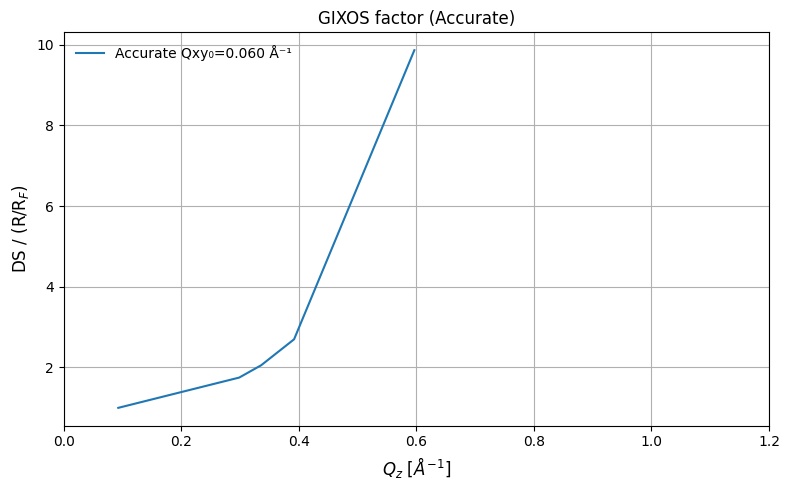

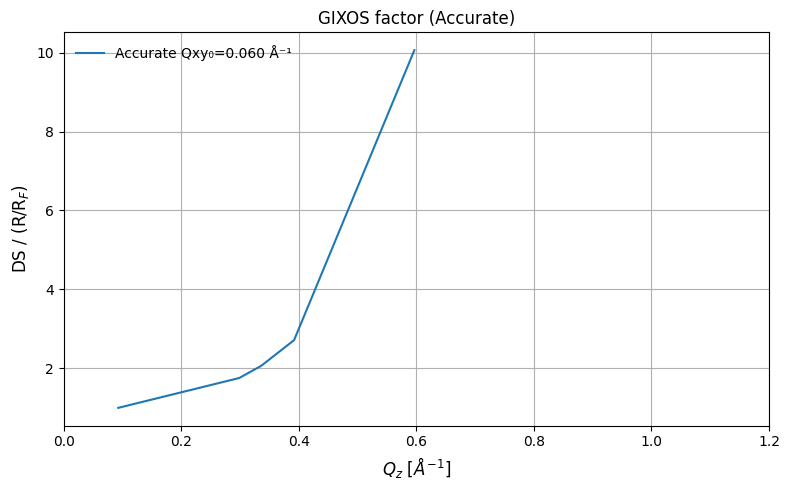

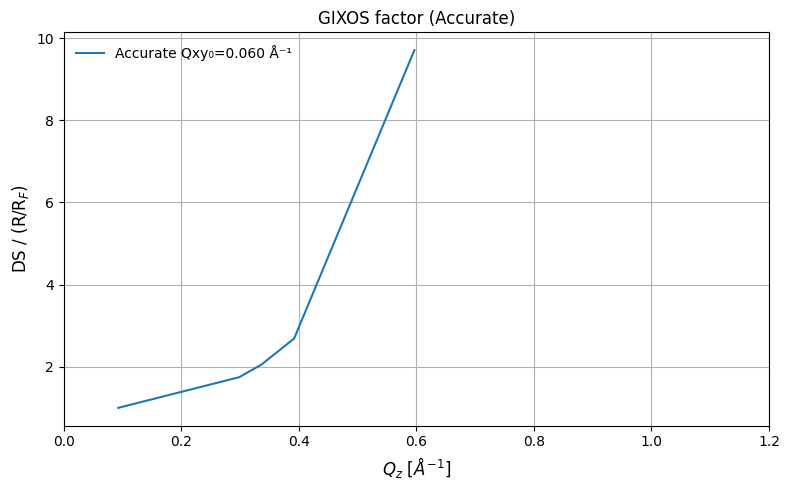

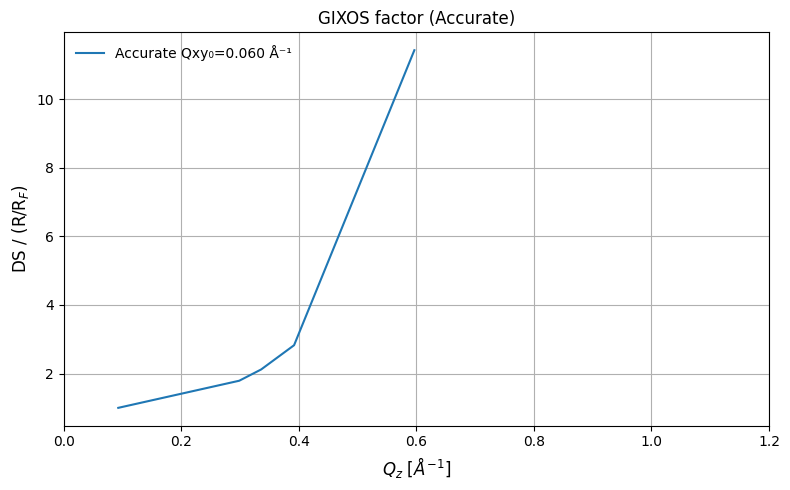

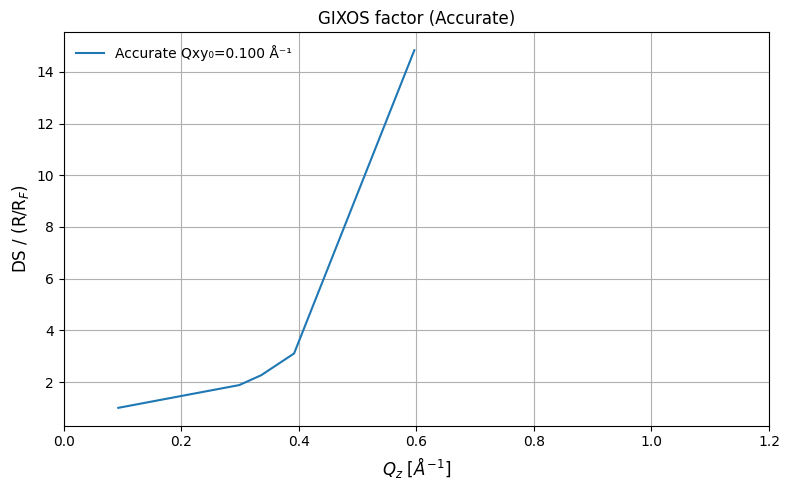

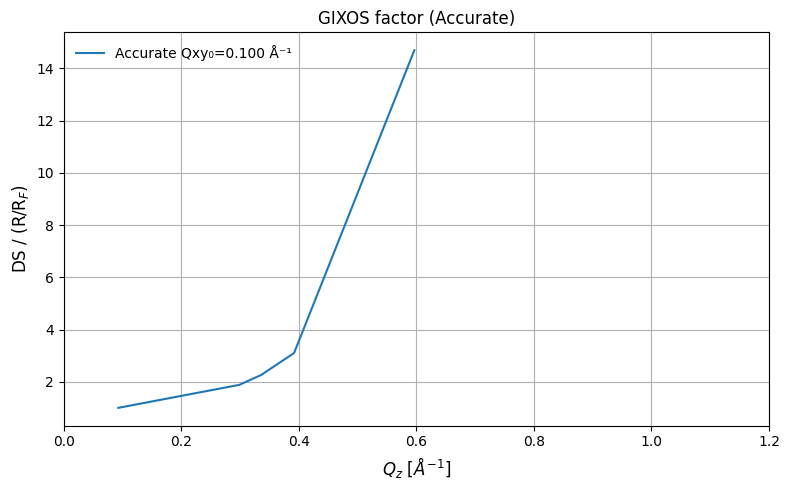

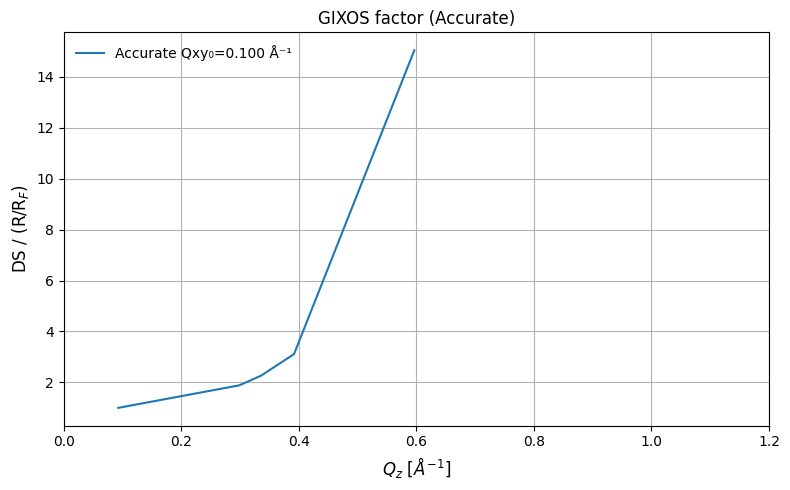

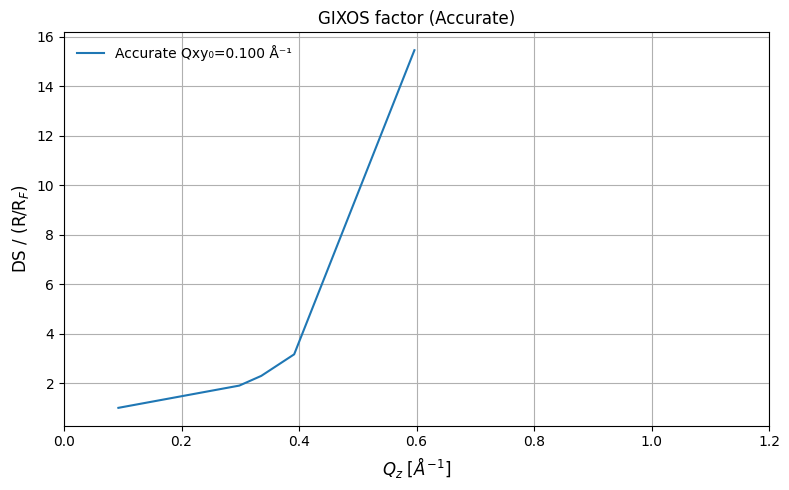

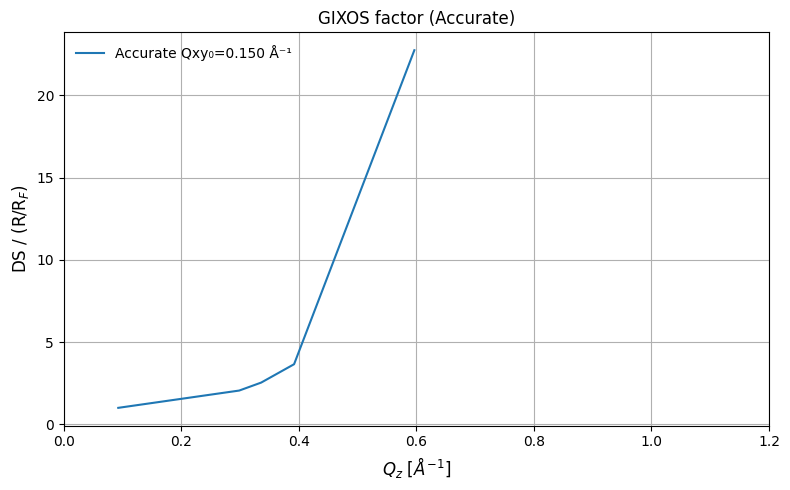

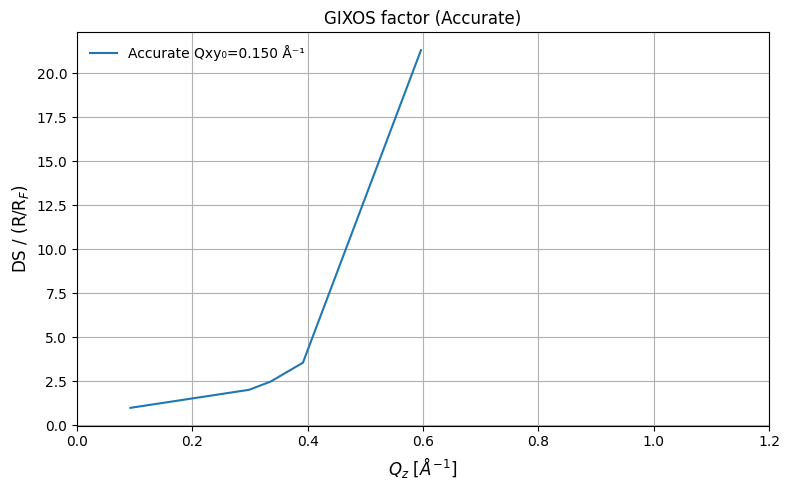

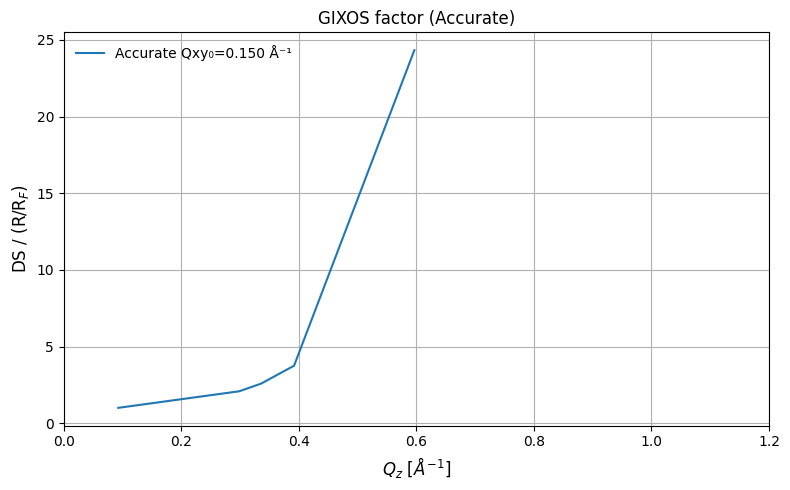

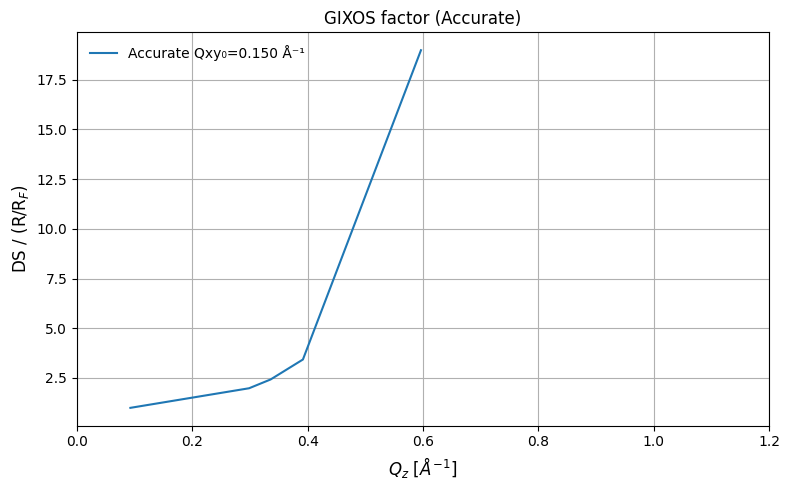

In [ ]:
import copy

model = {
    "tt": np.ones(len(qz_selected)),
    "Qz": np.ones(len(qz_selected)),
    "Qxy": np.zeros((len(qz_selected), GIXOS["Qxy"].shape[1]))
}

for idx in range(len(qz_selected)):
    rowidx_arr = np.where(GIXOS["Qz"] <= qz_selected[idx])[0]
    rowidx = rowidx_arr[-1]
    model["tt"][idx] = GIXOS["tt"][rowidx]
    model["Qz"][idx] = GIXOS["Qz"][rowidx]
    model["Qxy"][idx, :] = GIXOS["Qxy"][rowidx, :]

assume_model = {
    "1": copy.deepcopy(model),
    "2": copy.deepcopy(model)
}

CWM_model = copy.deepcopy(model)

model["DS_RRF"] = np.zeros((len(model["tt"]), len(qz_selected) - 1))
model["DS_term"] = np.zeros((len(model["tt"]), len(qz_selected) - 1))
model["RRF_term"] = np.zeros((len(model["tt"]), len(qz_selected) - 1))
assume_model["1"]["DS_RRF"] = np.zeros((len(model["tt"]), len(qz_selected) - 1))
assume_model["1"]["DS_term"] = np.zeros((len(model["tt"]), len(qz_selected) - 1))
assume_model["1"]["RRF_term"] = np.zeros((len(model["tt"]), len(qz_selected) - 1))
assume_model["2"]["DS_RRF"] = np.zeros((len(model["tt"]), len(qz_selected) - 1))
assume_model["2"]["DS_term"] = np.zeros((len(model["tt"]), len(qz_selected) - 1))
assume_model["2"]["RRF_term"] = np.zeros((len(model["tt"]), len(qz_selected) - 1))
CWM_model["DS_RRF"] = np.zeros((len(model["tt"]), len(qz_selected) - 1))
CWM_model["DS_term"] = np.zeros((len(model["tt"]), len(qz_selected) - 1))
CWM_model["RRF_term"] = np.zeros((len(model["tt"]), len(qz_selected) - 1))

for idx in range(GIXOS["GIXOS"].shape[1]):
    model["DS_RRF"][:, idx], model["DS_term"][:, idx], model["RRF_term"][:, idx] = calc_film_DS_RRF_integ(model["tt"], qxy0[idx], energy/1000, alpha_i, RqxyHW, DSqxyHW_real[idx], DSbetaHW, tension, temperature, kappa, amin)
    assume_model["1"]["DS_RRF"][:, idx], assume_model["1"]["DS_term"][:, idx], assume_model["1"]["RRF_term"][:, idx] = calc_film_DS_RRF_integ(model["tt"], qxy0[idx], energy/1000, alpha_i, RqxyHW, DSqxyHW_real[idx], DSbetaHW, tension, temperature, assume_kappa[0], amin)
    assume_model["2"]["DS_RRF"][:, idx], assume_model["2"]["DS_term"][:, idx], assume_model["2"]["RRF_term"][:, idx] = calc_film_DS_RRF_integ(model["tt"], qxy0[idx], energy/1000, alpha_i, RqxyHW, DSqxyHW_real[idx], DSbetaHW, tension, temperature, assume_kappa[1], amin)
    CWM_model["DS_RRF"][:, idx], CWM_model["DS_term"][:, idx], CWM_model["RRF_term"][:, idx] = calc_film_DS_RRF_integ(model["tt"], qxy0[idx], energy/1000, alpha_i, RqxyHW, DSqxyHW_real[idx], DSbetaHW, tension, temperature, 0, amin)

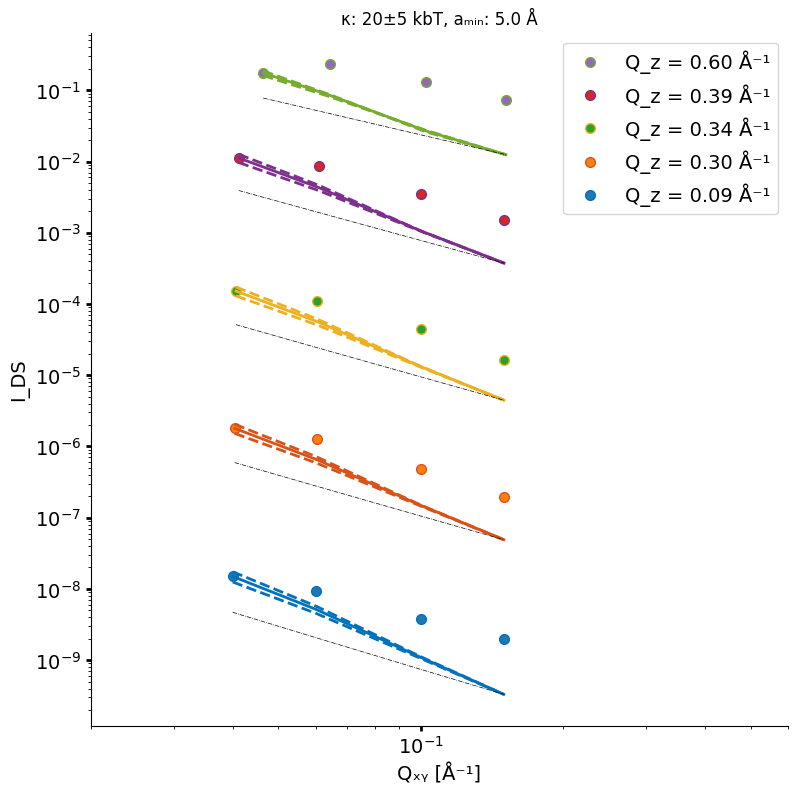

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Close previous figure if exists (handled by clearing in Python)
plt.close('all')

# Create figure
fig_refl = plt.figure(figsize=(9, 9))
ax = fig_refl.add_subplot(111)
legendtext = []

# First loop: Plot experimental points
for idx in range(len(model['Qz'])):
    plotrowidx = np.where(GIXOS['Qz'] <= qz_selected[idx])[0][-1]
    
    intensity = np.mean(GIXOS['GIXOS'][plotrowidx-1:plotrowidx+2, :] - GIXOS['bkg'], axis=0)
    scale_factor = 4 / (180 / np.pi)**2 / RFscaling * rho_b**2 / np.sin(np.radians(alpha_i)) * 100**idx

    ax.plot(
        GIXOS['Qxy'][plotrowidx, :],
        intensity * scale_factor,
        'o',
        markersize=7,
        markeredgecolor=colorset[idx],
        linewidth=1.5
    )

    legendtext.append(f"Q_z = {GIXOS['Qz'][plotrowidx]:.2f} Å⁻¹")

#colorset.reverse()  # Reverse the colorset to match the order of plots



# Second loop: Plot model fits and comparisons
for idx in range(len(model['Qz'])):
    plotrowidx = np.where(GIXOS['Qz'] <= qz_selected[idx])[0][-1]

    mean_intensity = np.mean(GIXOS['GIXOS'][plotrowidx-1:plotrowidx+2, 0] - GIXOS['bkg'], axis=0)
    norm_factor = mean_intensity / RFscaling / model['DS_term'][idx, 0]
    scale_factor = 4 / (180 / np.pi)**2 * rho_b**2 / np.sin(np.radians(alpha_i)) * 100**idx

    ax.plot(model['Qxy'][idx, :], model['DS_term'][idx, :] * norm_factor * scale_factor, 
            linewidth=2, color=colorset[idx])

    for m_idx, assume in enumerate([assume_model["1"], assume_model["2"]]):
        term = assume['DS_term'][idx, :] * model['DS_term'][idx, -1] / assume['DS_term'][idx, -1]
        ax.plot(assume['Qxy'][idx, :], term * norm_factor * scale_factor,
                linestyle='--', linewidth=2, color=colorset[idx])

    cwm_term = CWM_model['DS_term'][idx, :] * model['DS_term'][idx, -1] / CWM_model['DS_term'][idx, -1]
    ax.plot(CWM_model['Qxy'][idx, :], cwm_term * norm_factor * scale_factor,
            'k-.', linewidth=0.5)

# Formatting
#legendtext.reverse()  # Reverse the legend text to match the order of plots

ax.set_xlim([0.02, 0.6])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Qₓᵧ [Å⁻¹]', fontsize=14)
ax.set_ylabel('I_DS', fontsize=14)
ax.tick_params(labelsize=14, width=2, direction='out')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(legendtext, loc='upper right', frameon=True, fontsize=14, reverse = True)
ax.set_title(f"κ: {kappa:.0f}±{kappa_deviation:.0f} kbT, aₘᵢₙ: {amin:.1f} Å")

# Save the figure
filename = f"{sample}_{min(scan):05d}_{max(scan):05d}_Qxy.jpg"
plt.savefig(os.path.join(path_out, filename), dpi=300, bbox_inches='tight')
